In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import plotly.tools as tls
import plotly
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
init_notebook_mode(connected=True)


## Today, I will use my original dataset of the kickstarter projects. And I will utilize suh dataset and try to apply classifier model to predict it.

In [29]:
df_kick=pd.read_csv("./ks-projects.csv")
df_kick=df_kick.sample(10000,random_state=42).reset_index().drop('index',axis=1)

def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values    
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

resumetable(df_kick)

Dataset Shape: (10000, 15)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,ID,int64,0,10000,1576537356,675907016,361890770,13.29
1,name,object,0,9999,Deko,"Westside BJ's: The Gluten-Free, Organic Food T...",Crepe Diem Food Truck,13.29
2,category,object,0,158,Hardware,Food Trucks,Food,6.24
3,main_category,object,0,15,Technology,Food,Food,3.57
4,currency,object,0,14,USD,USD,USD,1.27
5,deadline,object,0,2617,2015-10-24,2015-02-01,2014-01-17,11.06
6,goal,float64,0,779,70000,250000,30000,6.50
7,launched,object,0,10000,2015-09-24 03:12:52,2015-01-02 20:55:07,2013-12-18 03:26:04,13.29
8,pledged,float64,0,4601,1888,1466,5723,10.16
9,state,object,0,6,failed,failed,failed,1.52


## Importin ML needed libraries

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

#Importing the auxiliar and preprocessing librarys 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding

In [30]:
df_kick.loc[df_kick.state.isin(['suspended', 'canceled','live']), 'state'] = 'failed'


In [31]:
df_kick = df_kick.loc[df_kick['state'].isin(['failed','successful'])]
print(df_kick.state.value_counts())

failed        6297
successful    3602
Name: state, dtype: int64


## Encoding state

In [32]:
targ_dict = {'failed': 0,
             'successful': 1 
            }

df_kick['state'] = df_kick['state'].map(targ_dict)


## Dealing with date

In [33]:
df_kick['launched'] = pd.to_datetime(df_kick['launched'])
df_kick['launched_date'] = df_kick['launched'].dt.date

df_kick['deadline'] = pd.to_datetime(df_kick['deadline'])
df_kick['deadline_date'] = df_kick['deadline'].dt.date

#Creating a new columns with Campaign total months
df_kick['time_campaign_d'] = (df_kick['deadline_date'] - df_kick['launched_date']).dt.days
df_kick['time_campaign_d'] = df_kick['time_campaign_d'].astype(int)

#removing outlier value
df_kick = df_kick[df_kick['time_campaign_d'] != 14867]

In [35]:
to_drop = ['ID', 'name', 'deadline', 'pledged', 'backers', 'goal',
            'usd pledged', 'usd_pledged_real','launched_date', 'deadline_date']
df_kick.drop(to_drop,axis=1,inplace=True)

In [36]:
df_kick.head()

,category,main_category,currency,launched,state,country,usd_goal_real,time_campaign_d
0,Hardware,Technology,USD,2015-09-24 03:12:52,0,US,70000.00,30
1,Food Trucks,Food,USD,2015-01-02 20:55:07,0,US,250000.00,30
2,Food,Food,USD,2013-12-18 03:26:04,0,US,30000.00,30
3,Fiction,Publishing,GBP,2016-10-24 15:44:36,0,GB,6839.01,30
4,Restaurants,Food,USD,2015-03-14 05:18:34,0,US,30000.00,60


In [37]:
df_kick = df_kick.assign(hour=df_kick.launched.dt.hour,
                         day=df_kick.launched.dt.day,          
                         month=df_kick.launched.dt.month,
                         year=df_kick.launched.dt.year).drop('launched', axis=1)
print(f'Shape before dummy transformation: {df_kick.shape}')
df_kick = pd.get_dummies(df_kick, columns=['category', 'main_category', 'currency', 'country'],\
                          prefix=['cat', 'main_cat', 'currency', 'country'], drop_first=True)

print(f'Shape after dummy transformation: {df_kick.shape}')

Shape before dummy transformation: (9899, 11)
Shape after dummy transformation: (9899, 213)


## MinMax Scaler¶


In [ ]:
num_cols = ['usd_goal_real', 'time_campaign_d']

for col in num_cols:
    df_kick[col] = (minmax_scale(df_kick[col], feature_range=(0,1)))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df_kick.drop('state', axis=1), df_kick['state'], 
                                                    test_size=.20, random_state=42)


In [41]:
print(f'Shape train: {X_train.shape}')
print(f'Shape test: {X_test.shape}')

Shape train: (7919, 212)
Shape test: (1980, 212)


In [53]:
clfs = []
seed = 3

clfs.append(('LogReg',
             Pipeline([("Scalar", StandardScaler()),
                        ("LogReg", LogisticRegression(n_jobs=-1, random_state=42))
                        ])))
clfs.append(("KNN", 
            Pipeline([("Scaler", StandardScaler()),
                      ("KNN", KNeighborsClassifier(n_jobs=-1))]))) 


clfs.append(("DecisionTreeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("DecisionTrees", DecisionTreeClassifier(random_state=42))]))) 

clfs.append(("RandomForestClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RandomForest", RandomForestClassifier(n_estimators=200, n_jobs=-1, 
                                                               random_state=42))]))) 

clfs.append(("GradientBoostingClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("GradientBoosting", GradientBoostingClassifier(n_estimators=200,
                                                                       random_state=42))]))) 

clfs.append(("RidgeClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("RidgeClassifier", RidgeClassifier(random_state=42))])))

clfs.append(("BaggingRidgeClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("BaggingClassifier", BaggingClassifier(n_jobs=-1, random_state=42))])))

clfs.append(("ExtraTreesClassifier",
             Pipeline([("Scaler", StandardScaler()),
                       ("ExtraTrees", ExtraTreesClassifier(n_jobs=-1, random_state=42))])))


## Following is the roc_auc score of all the classifier

In [54]:
scoring = 'roc_auc'
n_folds = 5
results, names  = [], [] 


for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, 
                                 cv= n_folds, scoring=scoring,
                                 n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)

LogReg: 0.680471 (+/- 0.007900)
KNN: 0.603801 (+/- 0.013365)
DecisionTreeClassifier: 0.576319 (+/- 0.011532)
RandomForestClassifier: 0.705844 (+/- 0.008732)
GradientBoostingClassifier: 0.724583 (+/- 0.006805)
RidgeClassifier: 0.657799 (+/- 0.009037)
BaggingRidgeClassifier: 0.656814 (+/- 0.012739)
ExtraTreesClassifier: 0.639005 (+/- 0.009557)


****
## We visualize the performance of all the classifier

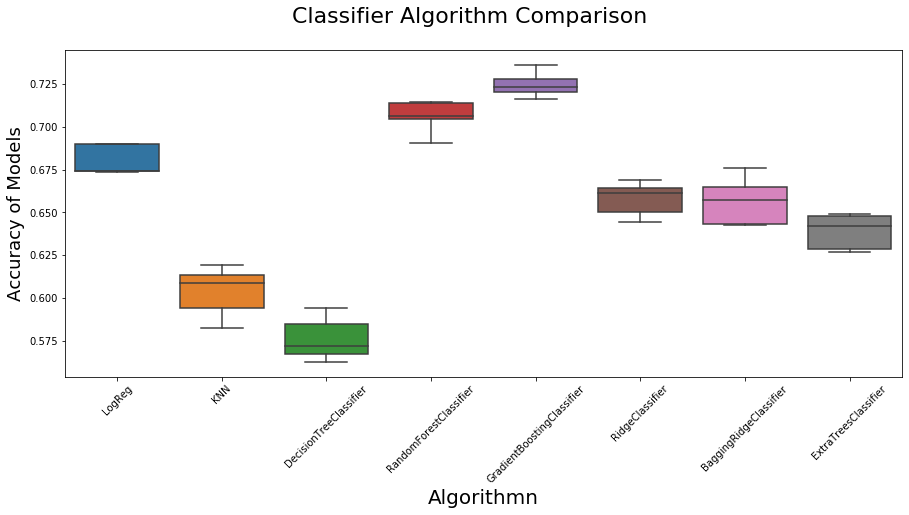

In [55]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn", fontsize=20)
ax.set_ylabel("Accuracy of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

plt.show()

In [56]:
from sklearn.metrics import roc_auc_score
def get_models_score(model, X, y, X_val, y_val):
    # Using the model in X_train and y_train desired
    model.fit(X, y)
    
    # Predicting our validation test
    y_pred = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, y_pred)
    
    return score, y_pred

In [59]:
gb_clf = GradientBoostingClassifier(n_estimators=500, random_state=42) 

score, pred = get_models_score(gb_clf, X_train, y_train,
                                X_test, y_test)

print(f'Score of: {score} \n')
# print(pred)

Score of: 0.7410131765528873 



## Among all classfier model, we can see that the decision tree classifier and the KNN classifier has the worst performance.
## In contrast, the Gradient Boosting Classifier and the Random Forest Classifier has the best performance. And the ROC_AUC score of the Gradient Boosting Classifier is 0.741

## And such difference may due to the distribution of the data is more non-linear, and using decision tree and KNN is harder is distinguish the data



